Assess ground truth vs. modeled winds at the location of the turbine

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import xarray as xr

In [15]:
### Point to data files
f_gt_arr = Path('/projects/wakedynamics/orybchuk/ldm-3d/logs/2022-12-01T22-01-37_inpaint_geo_raaw_kl1/images/test/inputs_gs-000000_e-000000_b-000000.npy')

ckl_in = Path('/projects/wakedynamics/orybchuk/ldm-3d/logs/2022-12-01T22-01-37_inpaint_geo_raaw_kl1/images/test/postprocessed')
ckl_files = list(Path(ckl_in).glob('*.npy'))
ckl_files.sort()
ckl_files = ckl_files[:100]  # Manually trim to reconstructed winds for this particular obs

In [16]:
### Prepare sample arrays for modeled data
# ncbatch = min(len(ccont_files), len(ucontp_files), len(ukl_files), len(uklp_files))
ncbatch = len(ckl_files)
tmp_samp = np.load(ckl_files[0])
ccond_shape = [ncbatch]+list(tmp_samp.shape)
    
tmp_kl = np.zeros(ccond_shape)
for i in range(ncbatch):
    tmp_kl[i,:,:,:,:] = np.load(ckl_files[i]).copy()

In [19]:
### Convert to Dataset
## Prepare metadata
xdim = np.arange(0, 1920, 15)
ydim = np.arange(0, 1920, 15)
zdim = np.arange(0, 480, 15)  # Chop vertical dim in half to avoid looking above capping inversion
coords = dict(x=xdim, y=ydim, z=zdim)

def unnorm(xp, xmin, xmax):
    '''
    Take data from [-1,1] back to the original values
    '''
    return (xp + 1)*0.5*(xmax-xmin)+xmin

umin, umax, vmin, vmax, wmin, wmax = 2.86975098, 12.5567627, -0.9810791, 4.91235352, -1.98095703, 2.5579834

## Create Dataset
ds_gt = xr.Dataset(coords=coords)
arr_gt = np.load(f_gt_arr)
ds_gt['u'] = (('x', 'y', 'z'), unnorm(arr_gt[0,0,:,:,:32], umin, umax))
ds_gt['v'] = (('x', 'y', 'z'), unnorm(arr_gt[0,1,:,:,:32], vmin, vmax))
ds_gt['w'] = (('x', 'y', 'z'), unnorm(arr_gt[0,2,:,:,:32], wmin, wmax))


ds_c = xr.Dataset(coords=coords)

ds_c['u_kl'] = (('sample', 'x', 'y', 'z'), unnorm(tmp_kl[:,0,:,:,:32], umin, umax))
ds_c['v_kl'] = (('sample', 'x', 'y', 'z'), unnorm(tmp_kl[:,1,:,:,:32], vmin, vmax))
ds_c['w_kl'] = (('sample', 'x', 'y', 'z'), unnorm(tmp_kl[:,2,:,:,:32], wmin, wmax))

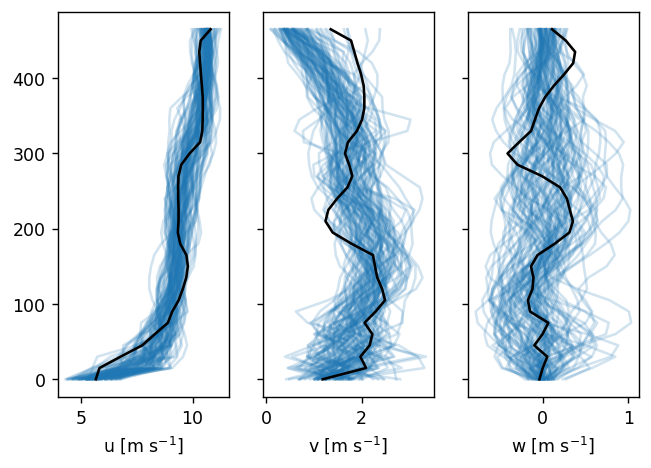

In [30]:
### Plot wind magnitudes
fig, ax = plt.subplots(1, 3, figsize=(6, 4), dpi=125, sharey=True)

i_ind = int(1800/15)
j_ind = int(960/15)

for i in range(len(ds_c['sample'])):
    ax[0].plot(ds_c['u_kl'].isel(sample=i, x=i_ind, y=j_ind),
               ds_c['z'],
               color='C0',
               alpha=0.2)
    ax[1].plot(ds_c['v_kl'].isel(sample=i, x=i_ind, y=j_ind),
               ds_c['z'],
               color='C0',
               alpha=0.2)
    ax[2].plot(ds_c['w_kl'].isel(sample=i, x=i_ind, y=j_ind),
               ds_c['z'],
               color='C0',
               alpha=0.2)

ax[0].plot(ds_gt['u'].isel(x=i_ind, y=j_ind), ds_gt['z'],
           color='k')
ax[1].plot(ds_gt['v'].isel(x=i_ind, y=j_ind), ds_gt['z'],
           color='k')
ax[2].plot(ds_gt['w'].isel(x=i_ind, y=j_ind), ds_gt['z'],
           color='k')
    
ax[0].set_xlabel('u [m s$^{-1}$]')
ax[1].set_xlabel('v [m s$^{-1}$]')
ax[2].set_xlabel('w [m s$^{-1}$]')
    
plt.show()

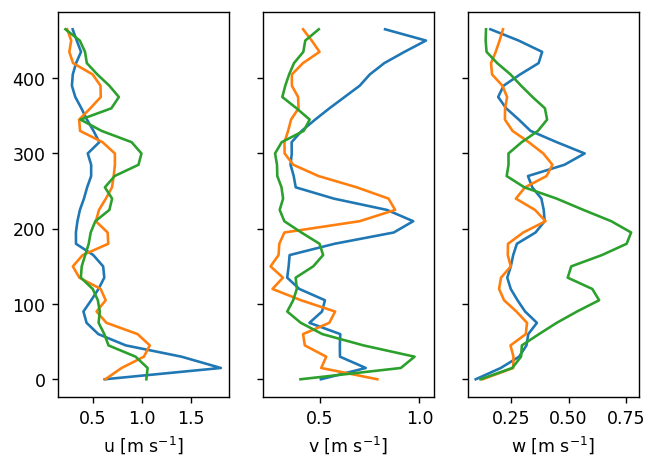

In [40]:
### Plot RMSE
fig, ax = plt.subplots(1, 3, figsize=(6, 4), dpi=125, sharey=True)

## Calculate RMSE at different locations
i_ind0 = int(1800/15)
j_ind0 = int(960/15)
i_ind1 = int((1800-360)/15)
j_ind1 = int(960/15)
i_ind2 = int((1800-1000)/15)
j_ind2 = int(960/15)

mse_u0 = (ds_c['u_kl'].isel(x=i_ind0, y=j_ind0) - ds_gt['u'].isel(x=i_ind0, y=j_ind0))**2
mse_v0 = (ds_c['v_kl'].isel(x=i_ind0, y=j_ind0) - ds_gt['v'].isel(x=i_ind0, y=j_ind0))**2
mse_w0 = (ds_c['w_kl'].isel(x=i_ind0, y=j_ind0) - ds_gt['w'].isel(x=i_ind0, y=j_ind0))**2
rmse_u0 = np.sqrt(mse_u0.sum('sample')/len(ds_c['sample']))
rmse_v0 = np.sqrt(mse_v0.sum('sample')/len(ds_c['sample']))
rmse_w0 = np.sqrt(mse_w0.sum('sample')/len(ds_c['sample']))

mse_u1 = (ds_c['u_kl'].isel(x=i_ind1, y=j_ind1) - ds_gt['u'].isel(x=i_ind1, y=j_ind1))**2
mse_v1 = (ds_c['v_kl'].isel(x=i_ind1, y=j_ind1) - ds_gt['v'].isel(x=i_ind1, y=j_ind1))**2
mse_w1 = (ds_c['w_kl'].isel(x=i_ind1, y=j_ind1) - ds_gt['w'].isel(x=i_ind1, y=j_ind1))**2
rmse_u1 = np.sqrt(mse_u1.sum('sample')/len(ds_c['sample']))
rmse_v1 = np.sqrt(mse_v1.sum('sample')/len(ds_c['sample']))
rmse_w1 = np.sqrt(mse_w1.sum('sample')/len(ds_c['sample']))

mse_u2 = (ds_c['u_kl'].isel(x=i_ind2, y=j_ind2) - ds_gt['u'].isel(x=i_ind2, y=j_ind2))**2
mse_v2 = (ds_c['v_kl'].isel(x=i_ind2, y=j_ind2) - ds_gt['v'].isel(x=i_ind2, y=j_ind2))**2
mse_w2 = (ds_c['w_kl'].isel(x=i_ind2, y=j_ind2) - ds_gt['w'].isel(x=i_ind2, y=j_ind2))**2
rmse_u2 = np.sqrt(mse_u2.sum('sample')/len(ds_c['sample']))
rmse_v2 = np.sqrt(mse_v2.sum('sample')/len(ds_c['sample']))
rmse_w2 = np.sqrt(mse_w2.sum('sample')/len(ds_c['sample']))

ax[0].plot(rmse_u0, ds_gt['z'])
ax[0].plot(rmse_u1, ds_gt['z'])
ax[0].plot(rmse_u2, ds_gt['z'])

ax[1].plot(rmse_v0, ds_gt['z'])
ax[1].plot(rmse_v1, ds_gt['z'])
ax[1].plot(rmse_v2, ds_gt['z'])

ax[2].plot(rmse_w0, ds_gt['z'])
ax[2].plot(rmse_w1, ds_gt['z'])
ax[2].plot(rmse_w2, ds_gt['z'])

ax[0].set_xlabel('u [m s$^{-1}$]')
ax[1].set_xlabel('v [m s$^{-1}$]')
ax[2].set_xlabel('w [m s$^{-1}$]')
    
plt.show()

In [42]:
np.sqrt(mse_u0.sum('sample')/100)

<xarray.DataArray (z: 32)>
array([0.62289267, 1.80346409, 1.4042046 , 0.83811301, 0.55895226,
       0.43933235, 0.40760054, 0.48620104, 0.56092029, 0.61925492,
       0.60786192, 0.5076798 , 0.33195722, 0.33108415, 0.34644778,
       0.37165825, 0.41276773, 0.4451343 , 0.48583825, 0.48605493,
       0.45128332, 0.56908193, 0.50995315, 0.44304974, 0.38681605,
       0.32493663, 0.29039729, 0.29918157, 0.33247609, 0.38326945,
       0.33958448, 0.29806997])
Coordinates:
    x        int64 1800
    y        int64 960
  * z        (z) int64 0 15 30 45 60 75 90 105 ... 375 390 405 420 435 450 465

In [32]:
mse_u0

<xarray.DataArray (sample: 100, z: 32)>
array([[-0.00443194,  2.02208231,  1.34829563, ..., -0.40249418,
        -0.48410602, -0.70200474],
       [-1.36199615, -0.3205946 , -1.04174403, ...,  0.42931433,
         0.37017079, -0.11907061],
       [-0.58581736,  2.75506124,  2.23403585, ...,  0.17030775,
         0.1856716 , -0.12323157],
       ...,
       [-0.12578218,  1.26538545,  1.02376752, ...,  0.43258554,
         0.27844879, -0.2765355 ],
       [ 0.41520378,  3.17944088,  2.14969666, ...,  0.49892083,
         0.41309836, -0.19462249],
       [ 0.03939939,  0.65456146,  1.86222492, ...,  0.28154297,
         0.22571972, -0.17086257]])
Coordinates:
    x        int64 1800
    y        int64 960
  * z        (z) int64 0 15 30 45 60 75 90 105 ... 375 390 405 420 435 450 465
Dimensions without coordinates: sample